In [1]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utilities import *
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime

In [2]:
load_optimzed_model = False

# Load Data

In [3]:
kaggle_data = pd.read_csv('C:\\Users\\I539001\\Desktop\\PA2\\AL\\FeedbackBoost\\Data\\Kaggle_Plant.csv')

In [4]:
Data_id = "Kaggel_plant"

In [5]:
kaggle_data.head()

,Unnamed: 0,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,...,L_10,A_5,B_5,C_5,ts_int,cnt_per_rtf,RUL,RUL_pw,phase,IMM_FAILURE
0,1,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,...,-65.524273,-100.0,-100.0,-100.0,1,51671,51671,120,1,0
1,2,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,...,-65.524273,-100.0,-100.0,-100.0,2,51671,51670,120,1,0
2,3,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,...,-71.139518,-100.0,-100.0,-100.0,3,51671,51669,120,1,0
3,4,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,...,-68.708337,-100.0,-100.0,-100.0,4,51671,51668,120,1,0
4,5,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,...,-67.030037,-100.0,-100.0,-100.0,5,51671,51667,120,1,0


In [6]:
kaggel_data_uncleaned = kaggle_data

# Some Exploratory Analysis

In [7]:
kaggle_data['rtf_id'].unique()

array([ 7,  8,  9, 11, 13, 14, 15, 16], dtype=int64)

In [8]:
data_16 = kaggle_data[kaggle_data['rtf_id'] == 16]

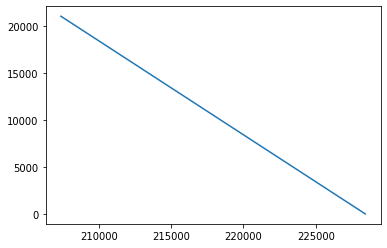

In [9]:
plt.plot(data_16["RUL"])

<Figure size 432x288 with 0 Axes>

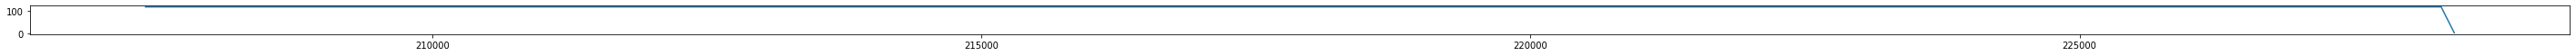

In [10]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (50,20)
fig, ax = plt.subplots()

ratio = 2
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.plot(data_16["RUL_pw"])


In [11]:
data_8 = kaggle_data[kaggle_data['rtf_id'] == 8]

<Figure size 3600x1440 with 0 Axes>

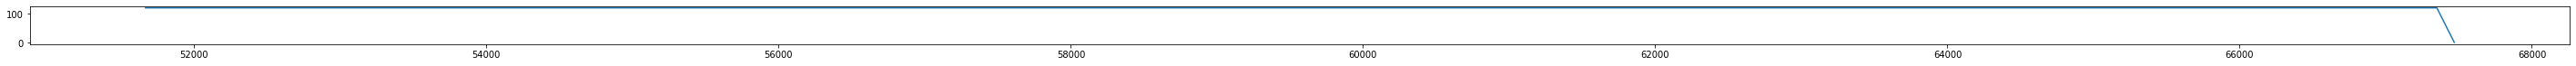

In [12]:
fig = plt.figure()
# plt.rcParams["figure.figsize"] = (50,10)
fig, ax = plt.subplots()

ratio = 2
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.plot(data_8["RUL_pw"])

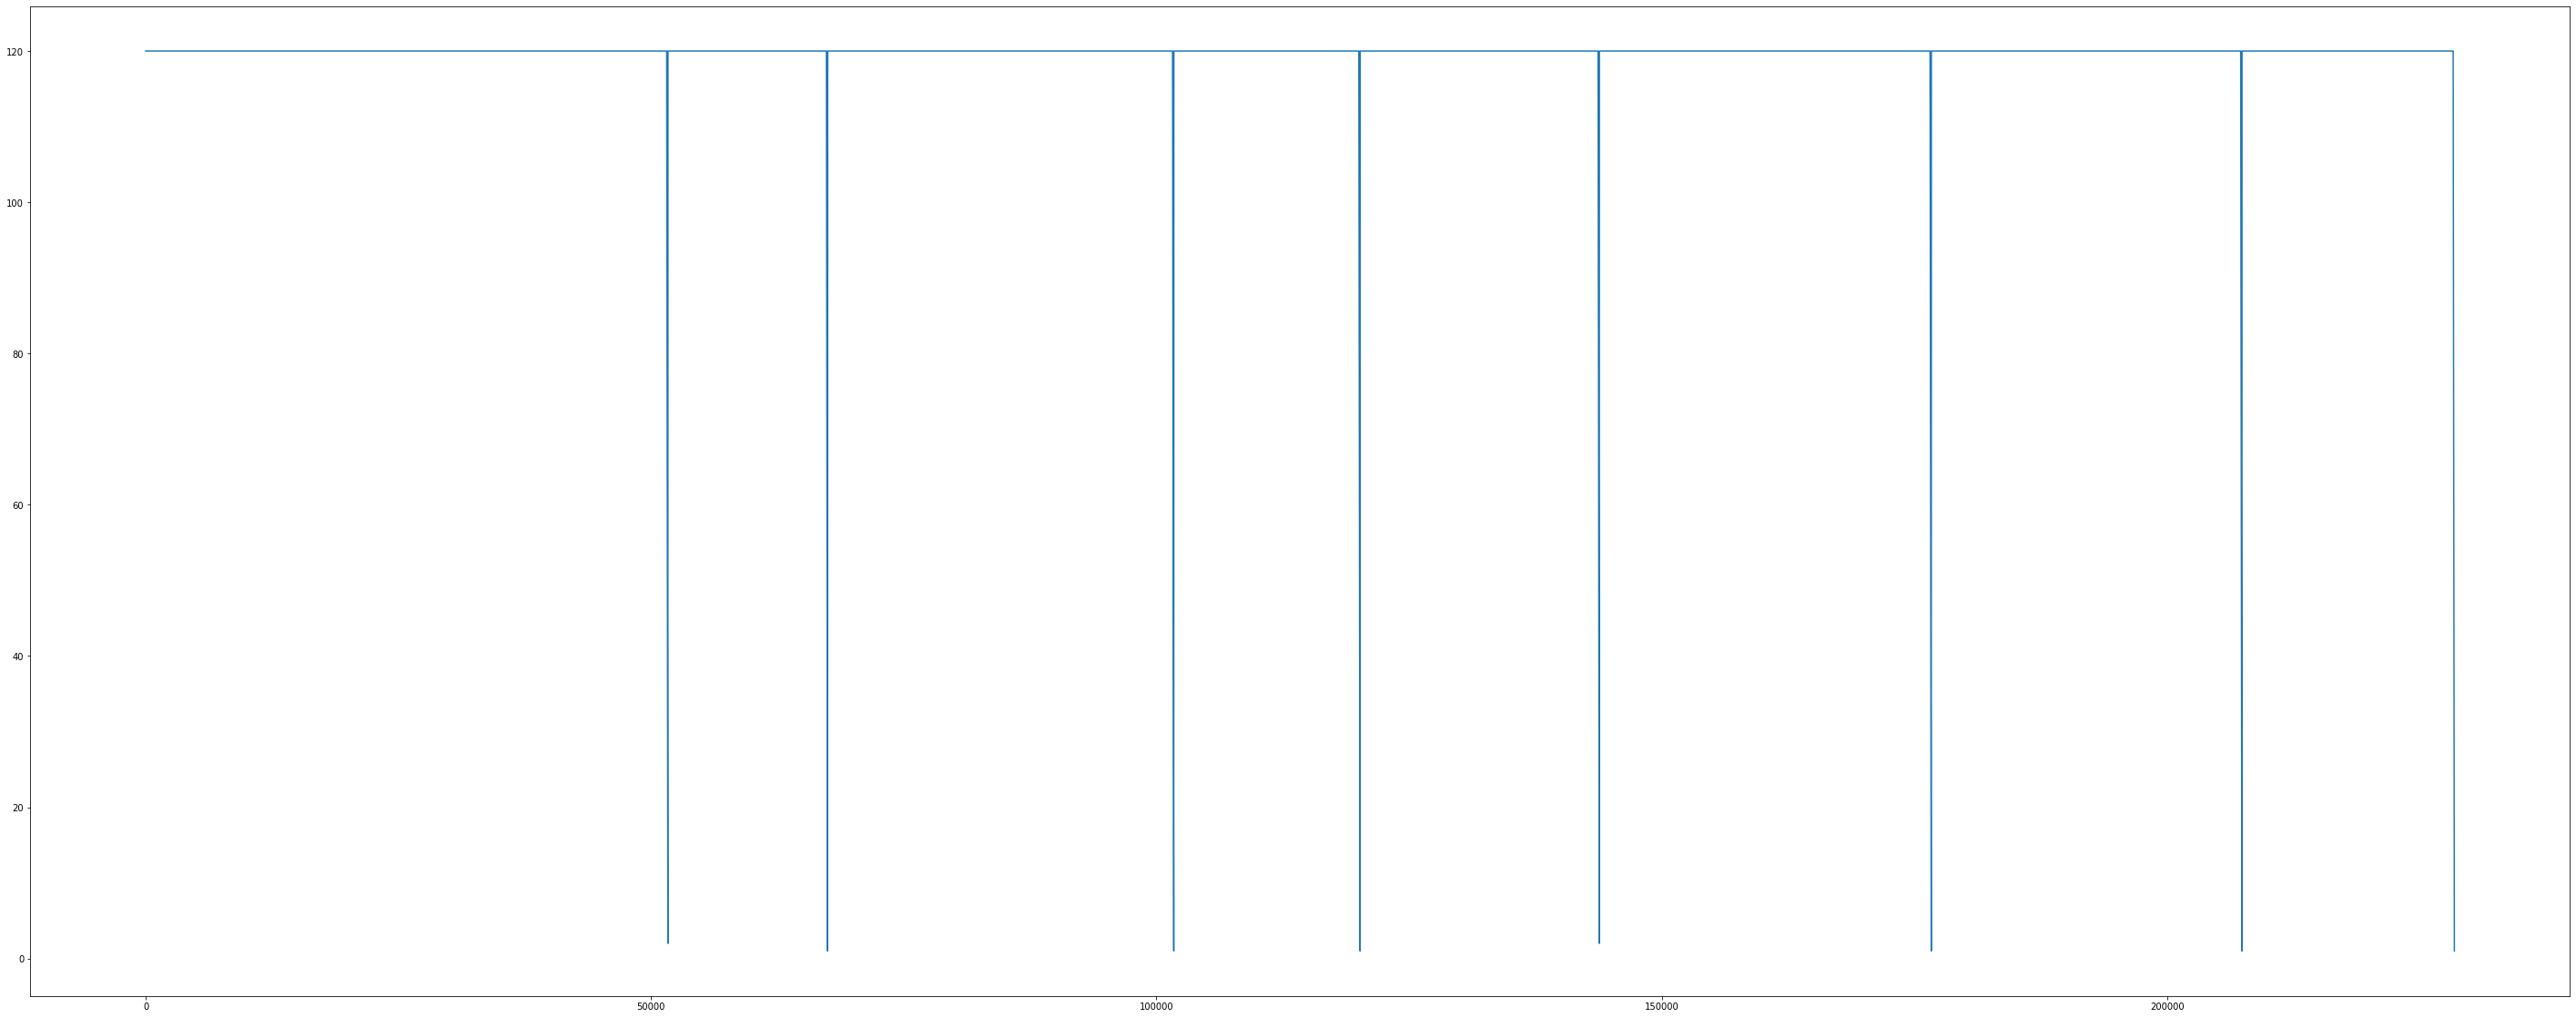

In [13]:
plt.plot(kaggle_data["RUL_pw"])

In [14]:
data_16["RUL_pw"].unique()

array([120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108,
       107, 106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,
        94,  93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,
        81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,
        68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,
        55,  54,  53,  52,  51,  50,  49,  48,  47,  46,  45,  44,  43,
        42,  41,  40,  39,  38,  37,  36,  35,  34,  33,  32,  31,  30,
        29,  28,  27,  26,  25,  24,  23,  22,  21,  20,  19,  18,  17,
        16,  15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,
         3,   2,   1], dtype=int64)

In [15]:
data_16["RUL_pw"].value_counts()

120    20902
119        1
32         1
33         1
34         1
       ...  
85         1
86         1
87         1
88         1
1          1
Name: RUL_pw, Length: 120, dtype: int64

In [16]:
data_8 = kaggle_data[kaggle_data['rtf_id'] == 8]
data_8["RUL"].iloc[-1]

1

In [17]:
# we only have 8 rtfs -> very few amount of data
rtf_ids = kaggle_data['rtf_id'].unique() # very few amount of data compared to cmaps (260 unique engine_ids alone in train set)
rtf_ids
# cross validation as solution to "zu wenig data"

array([ 7,  8,  9, 11, 13, 14, 15, 16], dtype=int64)

# Data Preparation

In [18]:
kaggle_data= kaggle_data.drop(['Unnamed: 0', 'ts_int', 'cnt_per_rtf', 'RUL_pw','phase','IMM_FAILURE'], axis=1) 
# run to failure id: z.B engine_id 

In [19]:
#define train dataset and test dataset: first, without cross validation. Just manually defining
train_data = kaggle_data.loc[kaggle_data['rtf_id'].isin(list(rtf_ids[:6]))]

In [20]:
train_data

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL
0,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,51671
1,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,51670
2,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,...,-71.781622,-84.311211,-93.610953,-23.687395,-97.509680,-71.139518,-100.0,-100.000000,-100.000000,51669
3,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,...,-57.552610,-84.311211,-85.852824,-12.887859,-89.826133,-68.708337,-100.0,-100.000000,-100.000000,51668
4,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,...,-45.735041,-84.311211,-65.288078,-10.575512,-67.853618,-67.030037,-100.0,-100.000000,-100.000000,51667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176653,14,32843,-91.678056,-26.233379,-12.630536,-24.762342,10.963635,-14.032787,33.220408,7.333377,...,-73.534037,2.981725,-88.804906,-29.331788,-92.362007,29.244765,-100.0,33.333333,53.846154,5
176654,14,32844,-91.936219,-43.134087,-12.523820,-24.749230,-22.380985,-24.760656,-4.559930,-24.490465,...,-73.534037,-53.350433,-85.824301,-33.498133,-92.362007,-53.948710,-100.0,-100.000000,-100.000000,4
176655,14,32845,-96.902050,-44.911147,-12.661026,-24.736117,-22.313266,-24.878689,-22.257606,-24.857461,...,-73.534037,-84.289836,-95.807188,-22.049697,-97.297092,-63.234256,-100.0,-100.000000,-100.000000,3
176656,14,32846,-96.810934,-61.625450,-12.554311,-24.736117,-22.299722,-24.826230,-22.244054,-24.844354,...,-73.534037,-84.289836,-96.434683,-31.685335,-97.297092,-63.861658,-100.0,-100.000000,-100.000000,2


In [21]:
extract_RUL_per_rtf_id(train_data, rul_column_name= "RUL")

,rtf_id,rul_per_rtf_id
0,7,2
1,8,1
2,9,1
3,11,1
4,13,2
5,14,1


In [22]:
y_train_RUL_per_cycle = train_data['RUL']
x_train_data = train_data.loc[:, train_data.columns!='RUL']

In [23]:
test_data = kaggle_data.loc[kaggle_data['rtf_id'].isin(list(rtf_ids[6:]))]
test_data

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL
176658,15,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,...,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0,30737
176659,15,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,...,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0,30736
176660,15,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,...,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0,30735
176661,15,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,...,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0,30734
176662,15,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,...,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0,30733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228407,16,21016,-91.921033,-54.939729,-12.645781,-24.723005,-22.313266,-24.747541,-22.298259,-24.844354,...,-20.766869,-80.250080,-87.664005,-25.706193,-92.346823,-30.123128,-100.0,-100.0,-100.0,5
228408,16,21017,-99.331815,-79.731577,-12.706761,-24.762342,-22.448703,-24.813115,-22.284708,-24.831247,...,-74.223021,-80.250080,-93.511124,-25.917343,-97.585605,-60.269783,-100.0,-100.0,-100.0,4
228409,16,21018,-99.331815,-79.731577,-12.706761,-24.736117,-22.313266,-24.826230,-22.271157,-24.857461,...,-74.223021,-80.250080,-93.511124,-26.303592,-97.585605,-59.062034,-100.0,-100.0,-100.0,3
228410,16,21019,-99.331815,-79.731577,-12.462840,-24.893464,-22.380985,-24.865574,-22.284708,-24.791926,...,-74.223021,-80.250080,-93.511124,-26.725892,-97.585605,-61.242256,-100.0,-100.0,-100.0,2


In [24]:
test_RUL_per_rtf_id = extract_RUL_per_rtf_id(test_data, rul_column_name= "RUL")

In [25]:
test_RUL_per_rtf_id

,rtf_id,rul_per_rtf_id
0,15,1
1,16,1


In [26]:
y_test_RUL_per_cycle = test_data['RUL']
x_test_data = test_data.loc[:, test_data.columns!='RUL']


In [27]:
x_test_data.head()

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_4,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5
176658,15,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,...,-97.493393,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0
176659,15,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,...,-75.069834,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0
176660,15,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,...,-50.426569,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0
176661,15,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,...,4.552677,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0
176662,15,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,...,73.363560,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0


In [28]:
x_train_data.columns

Index(['rtf_id', 'cycle', 'L_1', 'L_2', 'A_1', 'A_2', 'B_1', 'B_2', 'C_1',
       'C_2', 'A_3', 'A_4', 'B_3', 'B_4', 'C_3', 'C_4', 'L_3', 'L_4', 'L_5',
       'L_6', 'L_7', 'L_8', 'L_9', 'L_10', 'A_5', 'B_5', 'C_5'],
      dtype='object')

## Computing Remaining Useful Life

In [34]:
import importlib
import rul
importlib.reload(rul)

<module 'rul' from 'c:\\Users\\I539001\\Desktop\\PA2\\AL\\AutoRUL\\rul.py'>

In [36]:
# test_RUL_per_rtf_id = test_RUL_per_rtf_id["rul_per_rtf_id"]

In [37]:
test_RUL_per_rtf_id

0    1
1    1
Name: rul_per_rtf_id, dtype: int64

In [38]:
from importlib.resources import path


test  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, max_life=120, epochs= 30, path_to_trained_model= r"C:\Users\I539001\Desktop\PA2\AL\AutoRUL\logs\kaggel_plant_2022_9_25_17_22_29\ep001-loss59.648-val_loss43.670.h5")

In [40]:
# test_RUL_per_rtf_id


training (176658, 20) (176658,)
testing (51754, 20) (51754,)


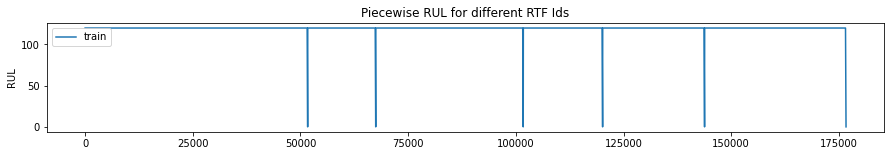

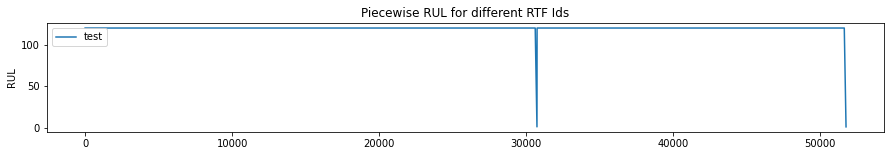

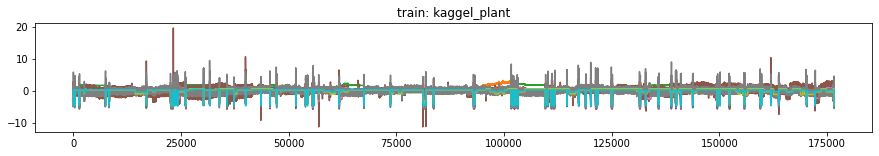

valid Configuration!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_2 (ModuleWra  (None, 5, 12, 1, 10)     6380      
 pper)                                                           
                                                                 
 batch_normalization_2 (Batc  (None, 5, 12, 1, 10)     40        
 hNormalization)                                                 
                                                                 
 module_wrapper_3 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_3 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (Non

(   y_batch_test  y_batch_pred_test
 0           1.0         119.184456
 1           1.0         119.068436,
         y_batch_train  y_batch_train
 0               120.0     119.188248
 1               120.0     119.194351
 2               120.0     119.196358
 3               120.0     119.192825
 4               120.0     119.187782
 ...               ...            ...
 176539            4.0     119.012627
 176540            3.0     118.993011
 176541            2.0     118.996025
 176542            1.0     119.031921
 176543            0.0     119.097794
 
 [176544 rows x 2 columns])

In [39]:
test.auto_rul()

In [48]:
test_RUL_per_rtf_id

,RUL_per_rtf_ID
0,1
1,1
